In [98]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Simulação e solução de equações diferenciais

O objetivo desse exercício é acompanhar uma variável de estado (potencial de membrana, V) ao longo do tempo, conforme o sistema dinâmico evolui. Essa evolução é dada por uma regra de evolução de estados - a dinâmica propriamente dita - que caracteriza o modelo; é também o que varia entre os três modelos que testaremos.

São eles:
#### Integra-e-dispara com vazamento:
\begin{equation}
C \frac{dV}{dt} = -g(V - V_r) + I
\end{equation}
#### Integra-e-dispara quadrático:
\begin{equation}
C \frac{dV}{dt} = -g(V - V_r)(V - V_t) + I
\end{equation}
#### Integra-e-dispara exponencial:
\begin{equation}
C \frac{dV}{dt} = -g(V - V_r) + g \Delta_T e^{\frac{V-V_t}{\Delta_T}} + I
\end{equation}

Nos modelos acima, $g$ é a condutância, $I$ é a corrente elétrica introjetada, $V_r$ é o potencial de repouso, $V_t$ é o potencial de limiar, $\Delta_T$ é o parâmetro de agudez ([?]; sharpness)

In [288]:
def dinamica(modelo,V,I = 1,V_repouso = -65,V_limiar = -55,C = 1,g=0.1,DeltaT = 2):
    '''
    V: Potencial de membrana atual [mV]
    V_repouso: Potencial de repouso [mV]
    V_limiar: Tensão limítrofe na membrana pro disparo de um potencial de ação [mV]
    I: Corrente injetada [uA/cm²]
    C: Capacitância da célula [uF/cm²]
    g: Condutância da membrana [mS/cm²]
    DeltaT: Parâmetro de agudez (sharpness) [mV]
    '''
    if modelo == 'leaky':
        return (-g*(V-V_repouso) + I)/C
    elif modelo == 'quadratic':
        return (g*(V-V_repouso)*(V-V_limiar) + I)/C
    elif modelo == 'exponential':
        return (-g*(V - V_repouso)+g*DeltaT*np.exp((V - V_limiar)/DeltaT) + I)/C
    else:
        print('Modelo inválido. Modelos disponíveis: "leaky","quadratic","exponential".')

def integracao(modelo = 'leaky',metodo='euler',I = 0,dt = 0.1,n_passos = 10_000,V_trunca = -50,V_reset = -70,
              V0 = -57,D=0.05,DeltaT=2):
    '''
    modelo: 'leaky', 'quadratic' ou 'exponential'
    metodo: 'euler' (Euler-Maruyama) ou 'srk2' (Stochastic Runge-Kutta II)
    timestep: duração do passo
    n_passos: número de passos
    V_trunca: potencial de truncagem da integração
    V_reset: potencial de reinicialização da dinâmica após truncagem
    '''
    V = np.zeros(n_passos) #inicializa o array que comportará a série do potencial
    V[0] = V0 #e o estado inicial
    spikes = []
    
    if metodo == 'srk2':
        #ruído da fonte em cada passo
        dW = np.random.randn(n_passos)
    
    for i in range(n_passos-1):
        if metodo == 'euler':
            V[i+1] = V[i] + dinamica(modelo, V[i] ,I) * dt #passo de Euler
        elif metodo == 'srk2':
            eta = np.sqrt(2*D*dt)*dW[i]
            F1 = dinamica(modelo,V[i] + np.sqrt(2*D*dt) * eta,I)
            F2 = dinamica(modelo,V[i] + dt * F1 * np.sqrt(2*D*dt) * eta,I)
            V[i+1] = V[i] + (dt/2)*(F1+F2) + np.sqrt(2*D*dt) * eta #Passo de Runge-Kutta II estocástico
        else:
            print('Método de integração numérica inválido.')
            break
        if V[i+1] > V_trunca:
            spikes.append(i)
            V[i] = 30 #gambiarra pra aparecer o spike como pico na escala do matplotlib
            V[i+1] = V_reset
        
    t = np.arange(n_passos)*dt #n_passos bins identicamente espaçadas com largura dt pra construir a escala
    t_spikes = t[spikes]
    return V, spikes, t, t_spikes

def curva_fi(corrente_max,corrente_step,modelo,metodo,dt,n_passos,V_trunca,V_reset,V0,D,DeltaT):
    corrente_atual = 0
    correntes = []
    frequencias = []
    while corrente_atual < corrente_max:
        correntes.append(corrente_atual)
        V,spikes,t,t_spikes = integracao(modelo,metodo,corrente_atual,dt,n_passos,V_trunca,V_reset,V0,D,DeltaT)
        
        frequencias.append(len(spikes))
        
        corrente_atual += corrente_step
    return frequencias,correntes

def estimate_isi(spike_times):
    pairwise_distances = []
    for i in range(len(spike_times)-1):
        pairwise_distances.append(spike_times[i+1] - spike_times[i])
    
    #plt.hist(pairwise_distances)
    #plt.xlabel('Intervalo entre spikes')
    #plt.ylabel('Número de spikes')
    return pairwise_distances

Text(0.5, 1.0, 'Integração do modelo integra-e-dispara exponencial')

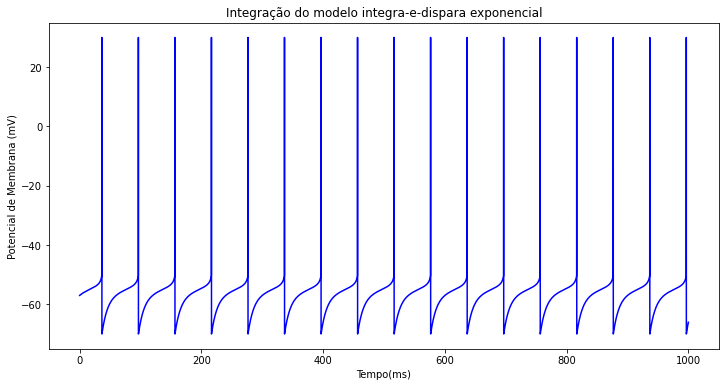

In [298]:
V,spikes,t,t_spikes = integracao(modelo = 'exponential',metodo='euler',I = 0.9,dt = 0.1,n_passos = 10_000,V_trunca = -50,V_reset = -70,
              V0 = -57,D=0.4)

plt.figure(figsize= [12,6])
plt.plot(t, V, 'b')
plt.xlabel('Tempo(ms)')
plt.ylabel('Potencial de Membrana (mV)')
#plt.xticks([], [])
plt.title('Integração do modelo integra-e-dispara exponencial')

Text(0.5, 1.0, 'Modelo integra-e-dispara quadrático')

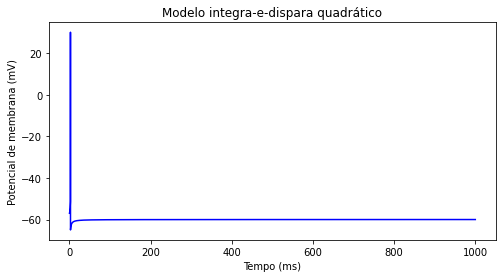

In [156]:
V,spikes,t,t_spikes = integracao(modelo = 'quadratic',metodo='euler',I = 2.5,dt = 0.1,n_passos = 10_000,V_trunca = -50,V_reset = -65,
              V0 = -57,D=0)

plt.figure(figsize= [8,4])
plt.plot(t, V, 'b')
plt.ylabel('Potencial de membrana (mV)')
plt.xlabel('Tempo (ms)')
plt.title('Modelo integra-e-dispara quadrático')

In [137]:
def estimate_isi(spike_times):
    pairwise_distances = []
    for i in range(len(spike_times)-1):
        pairwise_distances.append(spike_times[i+1] - spike_times[i])
    
    #plt.hist(pairwise_distances)
    #plt.xlabel('Intervalo entre spikes')
    #plt.ylabel('Número de spikes')
    return pairwise_distances

[59.300000000000004,
 35.89999999999999,
 40.10000000000002,
 40.099999999999994,
 40.69999999999999,
 27.299999999999983,
 39.700000000000045,
 63.69999999999999,
 34.5,
 34.69999999999999,
 36.400000000000034,
 44.5,
 41.0,
 31.199999999999932,
 51.30000000000007,
 37.700000000000045,
 32.59999999999991,
 70.40000000000009,
 159.29999999999995]

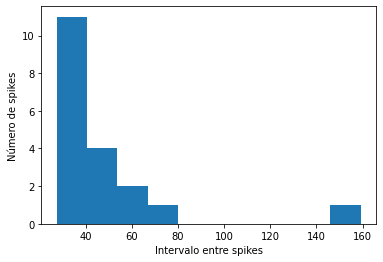

In [115]:
estimate_isi(t_spikes)

In [113]:
def curva_fi(corrente_max,corrente_step,modelo,metodo,dt,n_passos,V_trunca,V_reset,V0,D,DeltaT):
    corrente_atual = 0
    correntes = []
    frequencias = []
    while corrente_atual < corrente_max:
        correntes.append(corrente_atual)
        V,spikes,t,t_spikes = integracao(modelo,metodo,corrente_atual,dt,n_passos,V_trunca,V_reset,V0,D,DeltaT)
        
        frequencias.append(len(spikes))
        
        corrente_atual += corrente_step
    return frequencias,correntes

In [8]:
#frequencias,correntes = curva_fi(35,0.01,'leaky','srk2',dt=0.1,n_passos=10_000,
                                 #V_trunca = -50,V_reset = -70, V0 = -57,D=0.1)
    
#plt.figure(figsize= [16,8])
#plt.plot(correntes, frequencias, 'o') #'b' pra ser contínuo o traço
#plt.xlabel('Corrente (uA)')
#plt.ylabel('Frequência de disparos (Hz)')
#plt.xticks([], [])
#plt.title('Frequência de disparos em função da corrente injetada')

# Para dado conjunto de parâmetros, construa a curva f-I do modelo. Qual é a classe de excitabilidade de cada um deles?

In [114]:
frequencias_leaky,correntes_leaky = curva_fi(5,0.01,'leaky','euler',dt=0.1,n_passos=10_000,
                                 V_trunca = -50,V_reset = -70, V0 = -57,D=0,DeltaT=2)

Text(0.5, 1.0, 'Frequência de disparos em função da corrente injetada \n Modelo integra-e-dispara com vazamento')

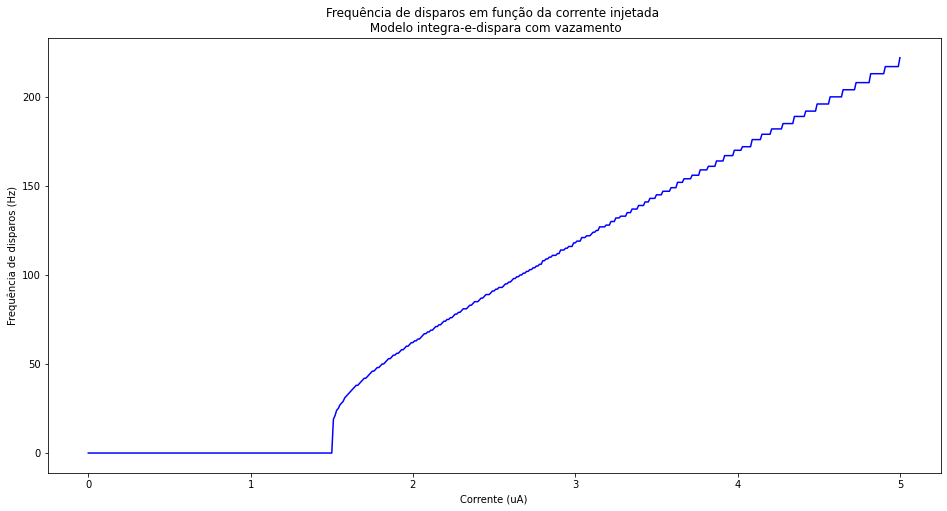

In [115]:
plt.figure(figsize= [16,8])
plt.plot(correntes_leaky, frequencias_leaky, 'b')
plt.xlabel('Corrente (uA)')
plt.ylabel('Frequência de disparos (Hz)')
plt.title('Frequência de disparos em função da corrente injetada \n Modelo integra-e-dispara com vazamento')

In [143]:
frequencias_quad,correntes_quad = curva_fi(8,0.01,'quadratic','euler',dt=0.1,n_passos=10_000,
                                 V_trunca = -50,V_reset = -65, V0 = -57,D=0,DeltaT = 2)

Text(0.5, 1.0, 'Frequência de disparos em função da corrente injetada')

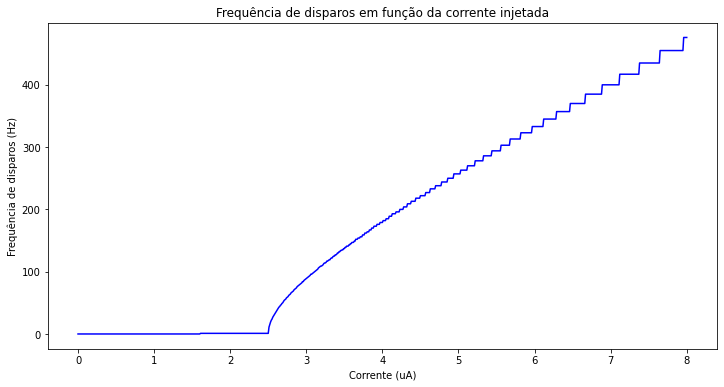

In [144]:
plt.figure(figsize= [12,6])
plt.plot(correntes_quad, frequencias_quad, 'b')
plt.xlabel('Corrente (uA)')
plt.ylabel('Frequência de disparos (Hz)')
#plt.xticks([], [])
plt.title('Frequência de disparos em função da corrente injetada')

In [158]:
frequencias_exp,correntes_exp = curva_fi(8,0.01,'exponential','euler',dt=0.1,n_passos=10_000,
                                 V_trunca = -50,V_reset = -65, V0 = -57,D=5,DeltaT = 2)

Text(0.5, 1.0, 'Frequência de disparos em função da corrente injetada')

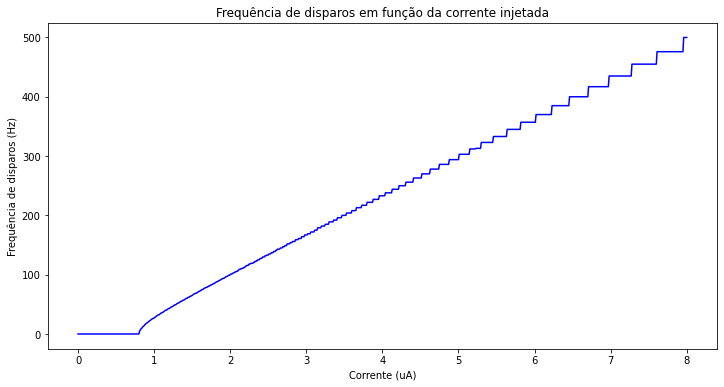

In [159]:
plt.figure(figsize= [12,6])
plt.plot(correntes_exp, frequencias_exp, 'b')
plt.xlabel('Corrente (uA)')
plt.ylabel('Frequência de disparos (Hz)')
#plt.xticks([], [])
plt.title('Frequência de disparos em função da corrente injetada')

Text(0.5, 1.0, 'Frequência de disparos em função da corrente injetada')

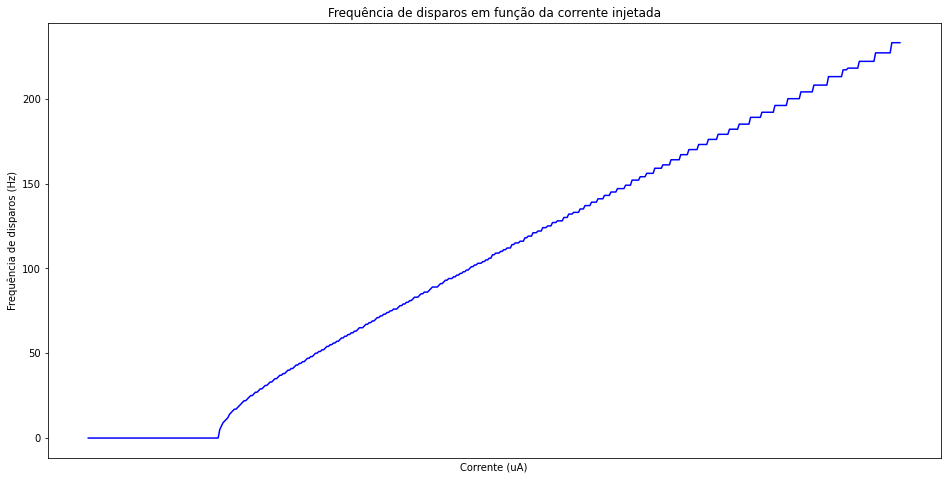

In [33]:
plt.figure(figsize= [16,8])
plt.plot(correntes_exp, frequencias_exp, 'b')
#plt.plot(correntes_exp[:100], frequencias_exp[:100], 'o')
plt.xlabel('Corrente (uA)')
plt.ylabel('Frequência de disparos (Hz)')
plt.xticks([], [])
plt.title('Frequência de disparos em função da corrente injetada')

# Estude a resposta dos modelos à injeção de ruído branco (média zero e variância D). Construa distribuições de ISI para algumas combinações de I, D.

In [160]:
modelos = ['exponential']
i=1
D = 0.1

for model in modelos:
    while i <= 2.5:
        for D in range(0,5):
            if D == 0:
                D = 0.1
            I_now = i
            D_now = D
            V,spikes,t,t_spikes = integracao(modelo = model,metodo='srk2',I = I_now,dt = 0.1,
                    n_passos = 10_000,V_trunca = -50,V_reset = -70,V0 = -57,D=D_now)
            plt.figure(figsize= [16,8])
            plt.plot(t, V, 'b')
            plt.xlabel('Tempo (ms)')
            plt.ylabel('Potencial de membrana (mV)')
            plt.title('I = ' + str(I_now) + ', D = ' + str(D_now))
            plt.savefig(model+'_'+str(I_now)+'_'+str(D)+'_spikes.jpg')
            
            plt.close()
            
            distances = estimate_isi(t_spikes)
            plt.title('Intervalo entre os spikes \n Parâmetros: I = ' + str(I_now) + ', D = ' + str(D_now))
            plt.ylabel('Número de ocorrências')
            plt.xlabel('Duração do intervalo (ms)')
            plt.hist(distances)
            plt.savefig(model+'_'+str(I_now)+'_'+str(D)+'_isi.jpg')
            plt.close()
            D+=1
        i+=0.5

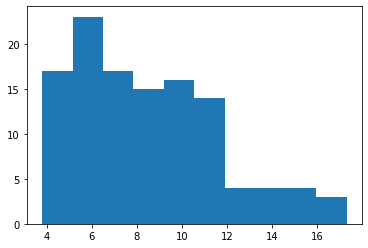

In [273]:
I_now = i
D_now = D
V,spikes,t,t_spikes = integracao(modelo = model,metodo='srk2',I = I_now,dt = 0.1,
                    n_passos = 10_000,V_trunca = -50,V_reset = -70,V0 = -57,D=D_now)
plt.figure(figsize= [16,8])
plt.plot(t, V, 'b')
plt.xlabel('Tempo (ms)')
plt.ylabel('Potencial de membrana (mV)')
plt.title('I = ' + str(I_now) + ', D = ' + str(D_now))
plt.savefig(model+'_'+str(i)+'_'+str(D)+'_spikes.png')

plt.close()

distances = estimate_isi(t_spikes)
            #plt.title('I = ' + str(I_now) + ', D = ' + str(D_now))
plt.hist(distances)
plt.savefig(model+'_'+str(i)+'_'+str(D)+'_isi.png')

Text(0.5, 1.0, 'I = 2, D = 2')

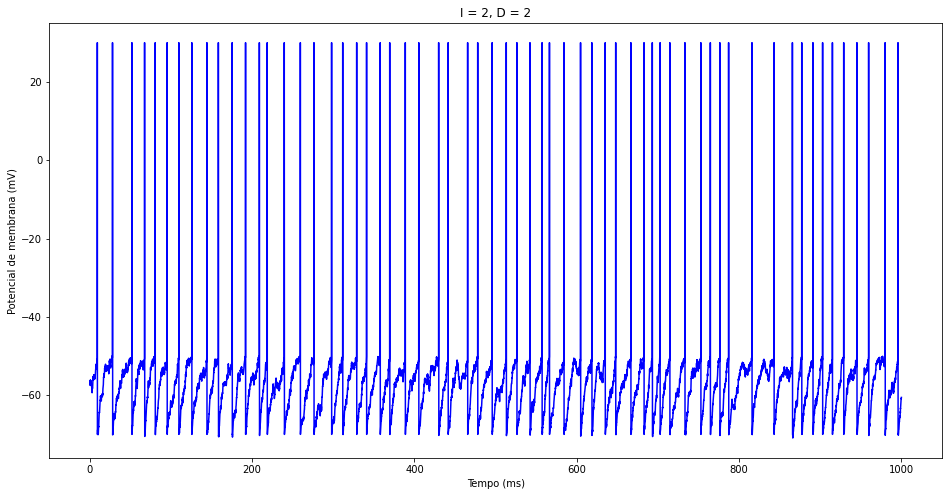

In [189]:
I_now = 2
D_now = 2
V,spikes,t,t_spikes = integracao(modelo = 'leaky',metodo='srk2',I = I_now,dt = 0.1,n_passos = 10_000,V_trunca = -50,V_reset = -70,
              V0 = -57,D=D_now)

plt.figure(figsize= [16,8])
plt.plot(t, V, 'b')
plt.xlabel('Tempo (ms)')
plt.ylabel('Potencial de membrana (mV)')
plt.title('I = ' + str(I_now) + ', D = ' + str(D_now))
#plt.xticks([], [])

In [245]:
#modelos = ['leaky','quadratic','exponential']

#for model in modelos:
 #   print(model)
#while i < 2.5:
#    i+=0.5
#    print(i)

for D in range(0,3):
    print(D)

0
1
2


(array([16., 25., 20., 19., 11.,  8.,  5.,  3.,  0.,  1.]),
 array([ 4.  ,  5.73,  7.46,  9.19, 10.92, 12.65, 14.38, 16.11, 17.84,
        19.57, 21.3 ]),
 <BarContainer object of 10 artists>)

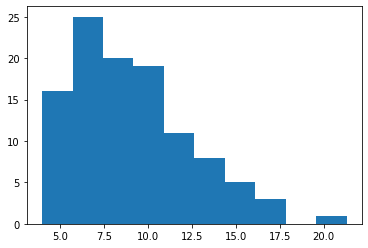

In [266]:
distances = estimate_isi(t_spikes)
#plt.title('I = ' + str(I_now) + ', D = ' + str(D_now))
plt.hist(distances)

Text(0.5, 1.0, 'I = 2, D = 2')

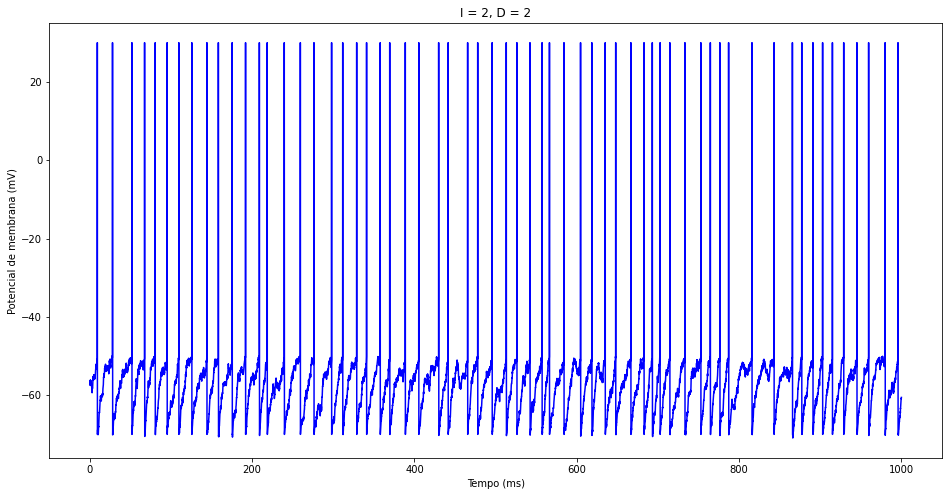

In [236]:
fig, ax = plt.subplots(figsize=(16,8))

#ax.plot(figsize= [16,8])
ax.plot(t, V, 'b')
#ax.set_y
ax.set_xlabel('Tempo (ms)')
ax.set_ylabel('Potencial de membrana (mV)')
ax.set_title('I = ' + str(I_now) + ', D = ' + str(D_now))
#plt.savefig('teste.png')

In [ ]:
axInset = ax.inset_axes([0.6,0.6,0.30,0.30],facecolor='white')
axInset.set_facecolor('w')
#axInset.tick_params(axis='both',labelcolor = 'red',pad=5)
plt.setp(axInset.get_xticklabels(), backgroundcolor="white")
#plt.setp(axInset.get_xticklabels(), backgroundcolor="white")
plt.setp(axInset.get_yticklabels(), backgroundcolor="white")
#axInset.set_edgecolor('white')
#axInset.set_facecolor('white')
axInset.hist(distances)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]},figsize=(16,8))

#ax.plot(figsize= [16,8])
ax1.plot(t, V, 'b')
#ax.set_y
ax1.set_xlabel('Tempo (ms)')
ax1.set_ylabel('Potencial de membrana (mV)')
ax1.set_title('I = ' + str(I_now) + ', D = ' + str(D_now))
#plt.savefig('/exercicio-solucao/plots_I_D/teste.png')

ax2.hist(distances)

/tmp/ipykernel_10348/875161890.py:7: RuntimeWarning: invalid value encountered in log
  freq = 1/(tau * np.log((V_inf - V_reset)/(V_inf-V_limiar)))*1000


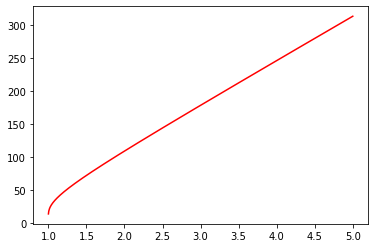

In [96]:
corrente = np.linspace(0,5,1000)#*1000 #x = I

tau = 10
V_inf = -60 + corrente*10 #V_r + I
V_limiar = -50
V_reset = -65
freq = 1/(tau * np.log((V_inf - V_reset)/(V_inf-V_limiar)))*1000

fig = plt.figure()

# plot the function
#plt. xlim(0,10)
#plt. ylim(0,200)
plt.plot(corrente,freq, 'r')

# show the plot
plt.show()

In [ ]:
frequencias_leaky,correntes_leaky = curva_fi(5,0.01,'leaky','euler',dt=0.1,n_passos=10_000,
                                 V_trunca = -50,V_reset = -70, V0 = -57,D=0,DeltaT=2)

plt.figure(figsize= [16,8])
plt.plot(correntes_leaky, frequencias_leaky, 'b')
plt.xlabel('Corrente (uA)')
plt.ylabel('Frequência de disparos (Hz)')
plt.title('Frequência de disparos em função da corrente injetada)')

corrente = np.linspace(0,5,1000)#*1000 #x = I

tau = 10
V_inf = -60 + corrente*10 #V_r + I
V_limiar = -50
V_reset = -65
freq = 1/(tau * np.log((V_inf - V_reset)/(V_inf-V_limiar)))*1000

fig = plt.figure()

# plot the function
#plt. xlim(0,10)
#plt. ylim(0,200)
plt.plot(corrente,freq, 'r')

# show the plot
plt.show()

Text(0.5, 1.0, 'Modelo integra-e-dispara com vazamento')

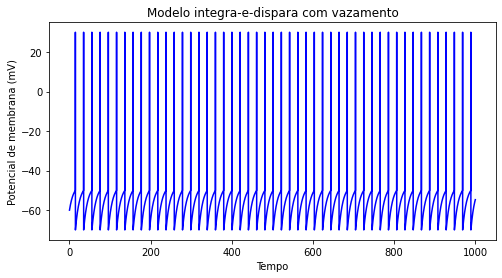

In [116]:
V,spikes,t,t_spikes = integracao(modelo = 'leaky',metodo='euler',I = 1.8,dt = 0.1,n_passos = 10_000,V_trunca = -50,V_reset = -70,
              V0 = -60,D=0)

plt.figure(figsize= [8,4])
plt.plot(t, V, 'b')
plt.ylabel('Potencial de membrana (mV)')
plt.xlabel('Tempo')
plt.title('Modelo integra-e-dispara com vazamento')

In [134]:
frequencias_leaky,correntes_leaky = curva_fi(8,0.01,'leaky','euler',dt=0.1,n_passos=10_000,
                                 V_trunca = -50,V_reset = -65, V0 = -57,D=0,DeltaT=2)

/tmp/ipykernel_10348/3566320433.py:11: RuntimeWarning: divide by zero encountered in log
  freq = 1/(tau * np.log((V_inf - V_reset)/(V_inf-V_limiar)))*1000
/tmp/ipykernel_10348/3566320433.py:11: RuntimeWarning: invalid value encountered in log
  freq = 1/(tau * np.log((V_inf - V_reset)/(V_inf-V_limiar)))*1000


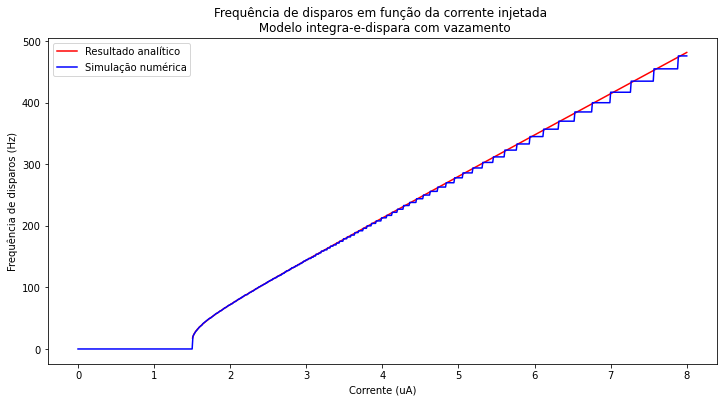

In [135]:
#fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.figure(figsize= [12,6])
corrente = np.linspace(0,8,1000)#*1000 #x = I

tau = 10
V_inf = -65 + corrente*10 #V_r + I
V_limiar = -50
V_reset = -65
freq = 1/(tau * np.log((V_inf - V_reset)/(V_inf-V_limiar)))*1000

plt.plot(corrente,freq, 'r',label='Resultado analítico')

plt.plot(correntes_leaky, frequencias_leaky, 'b',label='Simulação numérica')
plt.xlabel('Corrente (uA)')
plt.ylabel('Frequência de disparos (Hz)')
plt.title('Frequência de disparos em função da corrente injetada \n Modelo integra-e-dispara com vazamento')
plt.legend(loc='upper left')

In [201]:
def dinamica(modelo,V,I = 1,V_repouso = -65,V_limiar = -55,C = 1,g=0.1,DeltaT = 2):
    '''
    V: Potencial de membrana atual [mV]
    V_repouso: Potencial de repouso [mV]
    V_limiar: Tensão limítrofe na membrana pro disparo de um potencial de ação [mV]
    I: Corrente injetada [uA/cm²]
    C: Capacitância da célula [uF/cm²]
    g: Condutância da membrana [mS/cm²]
    DeltaT: Parâmetro de agudez (sharpness) [mV]
    '''
    if modelo == 'leaky':
        return (-g*(V-V_repouso) + I)/C
    elif modelo == 'quadratic':
        return (g*(V-V_repouso)*(V-V_limiar) + I)/C
    elif modelo == 'exponential':
        return (-g*(V - V_repouso)+g*DeltaT*np.exp((V - V_limiar)/DeltaT) + I)/C
    elif modelo == 'updown':
        return (-g*(V-V_repouso)*(V-V_limiar)*(V-((V_repouso + V_limiar)/2)) + I)/C
    else:
        print('Modelo inválido. Modelos disponíveis: "leaky","quadratic","exponential".')

def integracao(modelo = 'updown',metodo='srk2',I = 2,dt = 0.1,n_passos = 10_000,V_trunca = -50,V_reset = -70,
              V0 = -57,D=0.05,DeltaT=2,pulses=(10,1500,'alt')):
    '''
    modelo: 'leaky', 'quadratic','exponential' ou 'updown'
    metodo: 'euler' (Euler-Maruyama) ou 'srk2' (Stochastic Runge-Kutta II)
    timestep: duração do passo
    n_passos: número de passos
    V_trunca: potencial de truncagem da integração
    V_reset: potencial de reinicialização da dinâmica após truncagem
    '''
    V = np.zeros(n_passos) #inicializa o array que comportará a série do potencial
    V[0] = V0 #e o estado inicial
    spikes = []
    
    if metodo == 'srk2':
        #ruído da fonte em cada passo
        dW = np.random.randn(n_passos)
    
    for i in range(n_passos-1):
        if 1500 < i <1600:
            I = 2.5
        else:
            I = 0
        if metodo == 'euler':
            V[i+1] = V[i] + dinamica(modelo, V[i] ,I) * dt #passo de Euler
        elif metodo == 'srk2':
            eta = np.sqrt(2*D*dt)*dW[i]
            F1 = dinamica(modelo,V[i] + np.sqrt(2*D*dt) * eta,I)
            F2 = dinamica(modelo,V[i] + dt * F1 * np.sqrt(2*D*dt) * eta,I)
            V[i+1] = V[i] + (dt/2)*(F1+F2) + np.sqrt(2*D*dt) * eta #Passo de Runge-Kutta II estocástico
        else:
            print('Método de integração numérica inválido.')
            break
        if V[i+1] > V_trunca:
            spikes.append(i)
            V[i] = 30 #gambiarra pra aparecer o spike como pico na escala do matplotlib
            V[i+1] = V_reset
        
    t = np.arange(n_passos)*dt #n_passos bins identicamente espaçadas com largura dt pra construir a escala
    t_spikes = t[spikes]
    return V, spikes, t, t_spikes

Text(0.5, 1.0, 'Modelo integra-e-dispara quadrático')

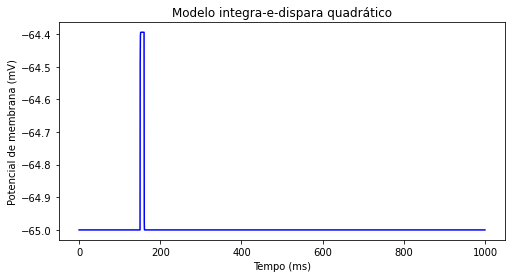

In [203]:
V, spikes, t, t_spikes = integracao(modelo = 'updown',metodo='euler',I = 2.5,dt = 0.1,n_passos = 10_000,V_trunca = -50,V_reset = -65,
              V0 = -65,D=0,pulses=(10,1500,'alt'))

plt.figure(figsize= [8,4])
plt.plot(t, V, 'b')
plt.ylabel('Potencial de membrana (mV)')
plt.xlabel('Tempo (ms)')
plt.title('Modelo integra-e-dispara quadrático')

In [247]:
def parametros_membrana(tau = 10, Er = -70, V_limiar = -50, V_reset = -75):
    return {'tau': tau, 'Er': Er, 'V_limiar': V_limiar, 'V_reset': V_reset}

def parametros_integracao(delta_t = 0.01, n_passos = 10_000):
    return {'delta_t': delta_t, 'n_passos': n_passos}

def criar_pulso(inicio = 0, fim = 100, amplitude = 0):
    return {'inicio': inicio, 'fim': fim, 'amplitude': amplitude}

def pulso_retangular(t,t0,tf,amplitude):
    pulso = np.zeros(len(t))
    pulso[(t >= t0) & (t <= tf)] = amplitude
    return pulso

In [248]:
pulsos = [criar_pulso(500, 600, 50), criar_pulso(1500, 1600, -50), criar_pulso(2500,2600,50), criar_pulso(3500,3600,-50)]

In [249]:
pulsos

[{'inicio': 500, 'fim': 600, 'amplitude': 50},
 {'inicio': 1500, 'fim': 1600, 'amplitude': -50},
 {'inicio': 2500, 'fim': 2600, 'amplitude': 50},
 {'inicio': 3500, 'fim': 3600, 'amplitude': -50}]

In [253]:
def parametros_membrana(tau = 10, Er = -70, V_limiar = -50, V_reset = -75):
    return {'tau': tau, 'Er': Er, 'V_limiar': V_limiar, 'V_reset': V_reset}

def parametros_integracao(delta_t = 0.01, n_passos = 10_000):
    return {'delta_t': delta_t, 'n_passos': n_passos}

def criar_pulso(inicio = 0, fim = 100, amplitude = 0):
    return {'inicio': inicio, 'fim': fim, 'amplitude': amplitude}

def pulso_retangular(t,t0,tf,amplitude):
    pulso = np.zeros(len(t))
    pulso[(t >= t0) & (t <= tf)] = amplitude
    return pulso

#def dinamica_biestavel(V,V_downstate,V_upstate,tau,I):
    #V[i], V_downstate = V_downstate, V_upstate = V_upstate, tau = tau, I=estimulo[i]
#    return -((V-V_downstate)*(V-V_upstate)*(V-((V_downstate + V_upstate)/2)) + I)/tau

def dinamica_biestavel(V, V_downstate = -74, V_upstate = -61, Er = -70, tau = 10, I = 0):
    Eq_inst = ((-V_downstate) + (-V_upstate))/2
    return -((V-V_downstate)*(V-V_upstate)*(V+Eq_inst))/(100*tau) + I/tau

def integra_e_dispara_biestavel(membrana = {'tau': 10, 'Er':-70, 'V_limiar': -50, 'V_reset': -70}, estados_biestaveis = {'V_downstate': -74, 'V_upstate': -61}, integracao = {'delta_t': 0.01, 'n_passos': 10000}, pulsos = [criar_pulso(0,0,0)]):
    '''
    Integrador da dinâmica biestável da membrana através do método de euler
    (Modelo) Integra e Dispara
    Parâmetros:
    membrana (dic) - parâmetros da membrana. Para alterá-los chame parametros_membrana()
    estados_biestaveis (dic) - parâmetros dos estados biestáveis down state e up state
    integracao (dic) - parâmetros de integração. Para alterá-los chame parametros_integracao()
    pulsos (array) - lista de pulsos aplicados à membrana. Para criar um novo pulso chame criar_pulsos()
    Retorna:
    t (array)- vetor para o tempo total de integração
    V (array) - vetor contendo o valor do potencial de membrana em cada instante de tempo
    spikes (int) - número de disparos detectados
    estimulo (array) - vetor contendo a integração dos pulsos aplicados à membrana
    '''
    #Parâmetros da membrana 
    tau = membrana['tau']
    #Er = membrana['Er']
    V_limiar = membrana['V_limiar']
    V_reset = membrana['V_reset']
    
    #Parâmetros da dinâmica biestável 
    V_downstate = estados_biestaveis['V_downstate']
    V_upstate = estados_biestaveis['V_upstate']
    
    # Parâmetros de integração
    delta_t = integracao['delta_t']
    n_passos = integracao['n_passos']

    # Criamos espaço "em branco" para armazenar os valores calculados
    V = np.zeros(n_passos)  # Array para valores dos potenciais V_i
    V[0] = V_downstate # O primeiro valor de V é a condição inicial que no nosso caso é dada pelo valor de repouso da membrana

    # Tempo 
    t = np.arange(n_passos)* delta_t

    # Pulso de corrente (estímulo)
    estimulo = sum(pulso_retangular(t,p['inicio'], p['fim'], p['amplitude']) for p in pulsos)

    D = 0.01
    spikes = []

    for i in range(n_passos - 1):  # avançando cada passo 
        dW = np.random.randn()
        
        V[i + 1] =  V[i] + delta_t * dinamica_biestavel(V[i], V_downstate = V_downstate, V_upstate = V_upstate, tau = tau, I=estimulo[i]) # implemente o passo do Método de Euler aqui!
        if V[i+1] >= V_limiar:
            spikes.append(i)
            V[i] = 40
            V[i+1] = V_upstate
    return t, V, spikes, estimulo

Text(0, 0.5, 'Estímulo Aplicado (mV)')

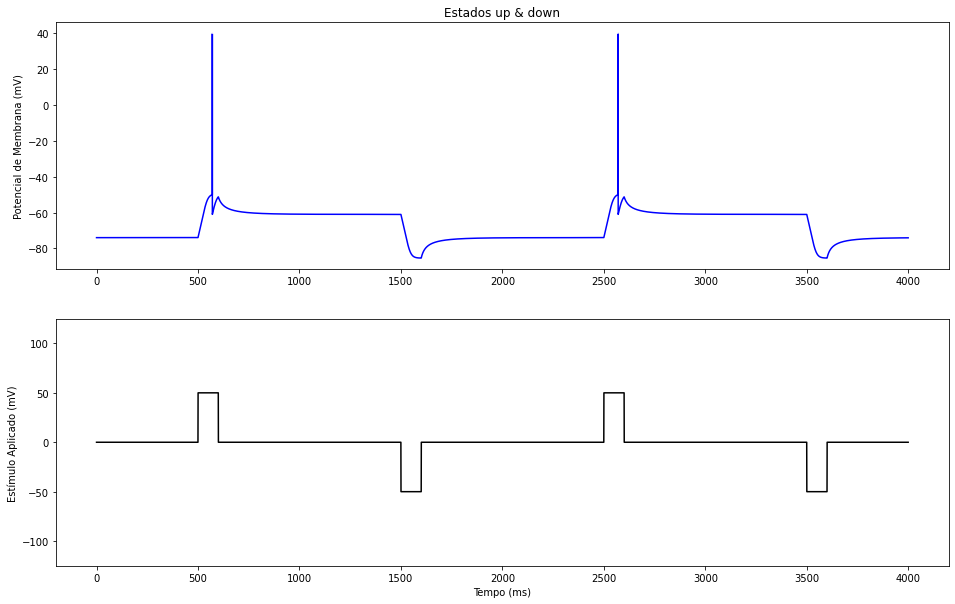

In [257]:
pulsos = [criar_pulso(500, 600, 50), criar_pulso(1500, 1600, -50), criar_pulso(2500,2600,50), criar_pulso(3500,3600,-50)]

t, V, disparos, estimulo = integra_e_dispara_biestavel(membrana = parametros_membrana(tau = 100, Er=-75), integracao = parametros_integracao(delta_t = 0.1, n_passos=40000), pulsos = pulsos)
plt.figure(figsize= [16,10])
plt.subplot(211)
plt.plot(t, V, 'b')
plt.plot(t[disparos], V[disparos], 'w')
plt.ylabel('Potencial de Membrana (mV)')
plt.title('Estados up & down')

plt.subplot(212)
plt.plot(t, estimulo, 'k')
plt.ylim(-125,125)
plt.xlabel('Tempo (ms)')
plt.ylabel('Estímulo Aplicado (mV)')

Text(0.5, 1.0, 'Modelo de estados up e down')

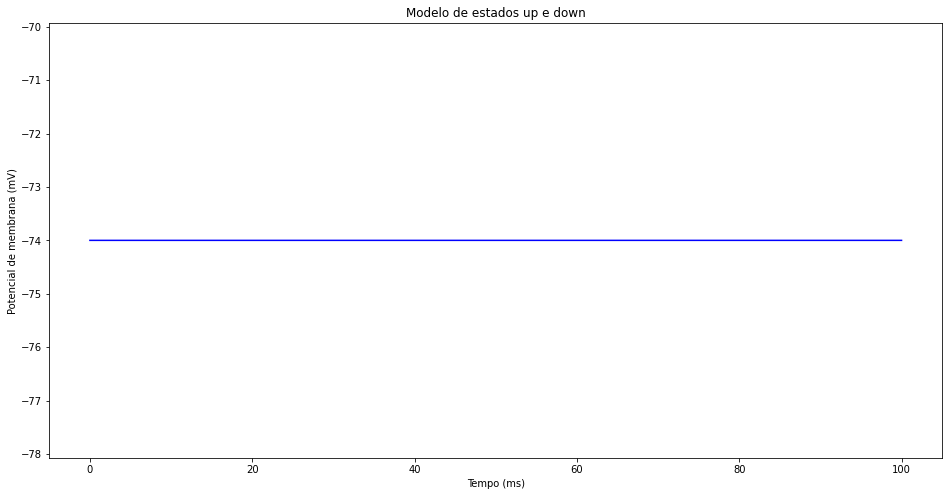

In [252]:
plt.figure(figsize= [16,8])
plt.plot(t, V, 'b')
plt.ylabel('Potencial de membrana (mV)')
plt.xlabel('Tempo (ms)')
plt.title('Modelo de estados up e down')

In [ ]:
eta = np.sqrt(2*D*dt)*dW[i]
            F1 = dinamica(modelo,V[i] + np.sqrt(2*D*dt) * eta,I)
            F2 = dinamica(modelo,V[i] + dt * F1 * np.sqrt(2*D*dt) * eta,I)
            V[i+1] = V[i] + (dt/2)*(F1+F2) + np.sqrt(2*D*dt) * eta #Passo de Runge-Kutta II estocástico

In [280]:
def integra_e_dispara_biestavel(membrana = {'tau': 5, 'Er':-70, 'V_limiar': -50, 'V_reset': -70}, estados_biestaveis = {'V_downstate': -74, 'V_upstate': -61}, integracao = {'delta_t': 0.01, 'n_passos': 10000}, pulsos = [criar_pulso(0,0,0)]):
    '''
    Integrador da dinâmica biestável da membrana através do método de euler
    (Modelo) Integra e Dispara
    Parâmetros:
    membrana (dic) - parâmetros da membrana. Para alterá-los chame parametros_membrana()
    estados_biestaveis (dic) - parâmetros dos estados biestáveis down state e up state
    integracao (dic) - parâmetros de integração. Para alterá-los chame parametros_integracao()
    pulsos (array) - lista de pulsos aplicados à membrana. Para criar um novo pulso chame criar_pulsos()
    Retorna:
    t (array)- vetor para o tempo total de integração
    V (array) - vetor contendo o valor do potencial de membrana em cada instante de tempo
    spikes (int) - número de disparos detectados
    estimulo (array) - vetor contendo a integração dos pulsos aplicados à membrana
    '''
    #Parâmetros da membrana 
    tau = membrana['tau']
    #Er = membrana['Er']
    V_limiar = membrana['V_limiar']
    V_reset = membrana['V_reset']
    
    #Parâmetros da dinâmica biestável 
    V_downstate = estados_biestaveis['V_downstate']
    V_upstate = estados_biestaveis['V_upstate']
    
    # Parâmetros de integração
    delta_t = integracao['delta_t']
    n_passos = integracao['n_passos']

    # Criamos espaço "em branco" para armazenar os valores calculados
    V = np.zeros(n_passos)  # Array para valores dos potenciais V_i
    V[0] = V_downstate # O primeiro valor de V é a condição inicial que no nosso caso é dada pelo valor de repouso da membrana

    # Tempo 
    t = np.arange(n_passos)* delta_t

    # Pulso de corrente (estímulo)
    estimulo = sum(pulso_retangular(t,p['inicio'], p['fim'], p['amplitude']) for p in pulsos)

    spikes = []
    dW = np.random.randn(n_passos)
    D = 2

    for i in range(n_passos - 1):  # avançando cada passo 
        eta = np.sqrt(2*D*delta_t)*dW[i]
        F1 = dinamica_biestavel(V[i] + np.sqrt(2*D*delta_t) * eta,I=estimulo[i])
        F2 = dinamica_biestavel(V[i] + delta_t * F1 * np.sqrt(2*D*delta_t) * eta,I=estimulo[i])
        V[i+1] = V[i] + ((delta_t/2)*(F1+F2) + np.sqrt(2*D*delta_t) * eta)/10 #Passo de Runge-Kutta II estocástico
        
        #V[i + 1] =  V[i] + delta_t * dinamica_biestavel(V[i], V_downstate = V_downstate, V_upstate = V_upstate, tau = tau, I=estimulo[i]) # implemente o passo do Método de Euler aqui!
        if V[i+1] >= V_limiar:
            spikes.append(i)
            V[i] = 40
            V[i+1] = V_upstate
    return t, V, spikes, estimulo

#dinamica_biestavel(V, V_downstate = -74, V_upstate = -61, Er = -70, tau = 10, I = 0):
#dinamica(modelo,V,I = 1,V_repouso = -65,V_limiar = -55,C = 1,g=0.1,DeltaT = 2):

Text(0, 0.5, 'Estímulo Aplicado (mV)')

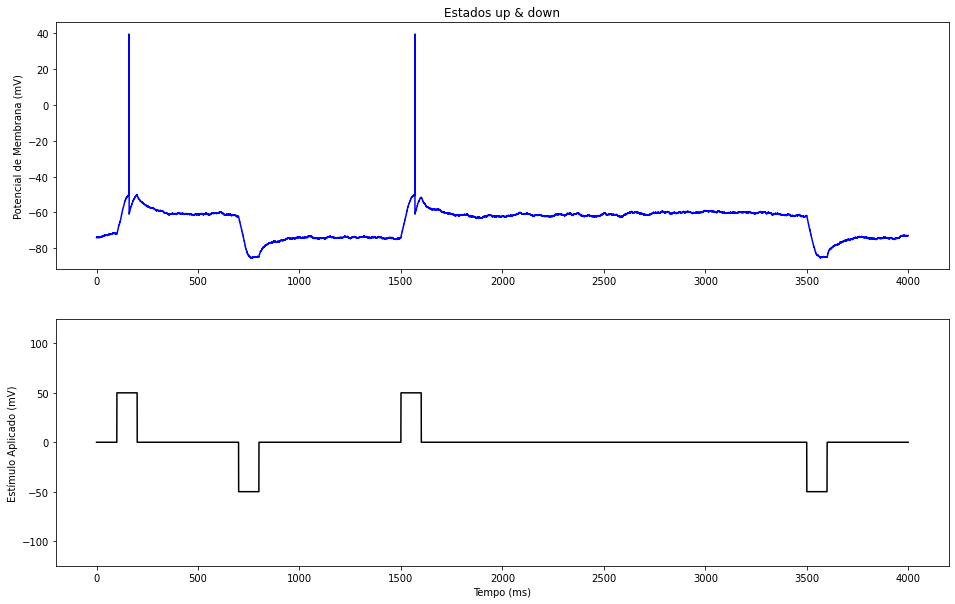

In [282]:
pulsos = [criar_pulso(100, 200, 50), criar_pulso(700, 800, -50), criar_pulso(1500,1600,50), criar_pulso(3500,3600,-50)]

t, V, disparos, estimulo = integra_e_dispara_biestavel(membrana = parametros_membrana(tau = 100, Er=-75), integracao = parametros_integracao(delta_t = 0.1, n_passos=40000), pulsos = pulsos)
plt.figure(figsize= [16,10])
plt.subplot(211)
plt.plot(t, V, 'b')
plt.plot(t[disparos], V[disparos], 'w')
plt.ylabel('Potencial de Membrana (mV)')
plt.title('Estados up & down')

plt.subplot(212)
plt.plot(t, estimulo, 'k')
plt.ylim(-125,125)
plt.xlabel('Tempo (ms)')
plt.ylabel('Estímulo Aplicado (mV)')